In [1]:
%load_ext autoreload
%autoreload 2

from diffusers import ControlNetModel
from text3d2video.cross_frame_attn import CrossFrameAttnProcessor
from text3d2video.pipelines.my_pipeline import  MyPipeline
import torch

dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/sd-controlnet-depth"
device = torch.device('cuda')

controlnet = ControlNetModel.from_pretrained(
    controlnet_repo,
    torch_dtype=torch.float16
).to(device)

my_pipe = MyPipeline.from_pretrained(
    sd_repo,
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=dtype
).to(device)

# cross-frame attention
attn_processor = CrossFrameAttnProcessor(unet_chunk_size=2)
my_pipe.unet.set_attn_processor(attn_processor)

/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Keyword arguments {'safety_checker': None} are not expected by MyPipeline and will be ignored.
Loading pipeline components...:  40%|████      | 2/5 [00:00<00:00,  7.65it/s]/home/jorge/miniconda3

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact backflip:latest, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


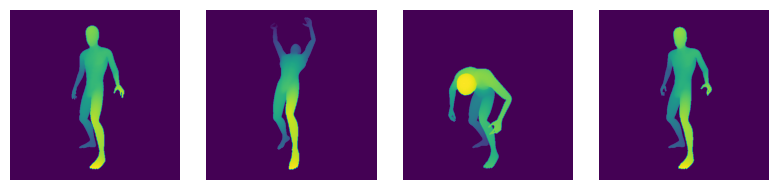

In [2]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map
from text3d2video.util import front_camera
import text3d2video.wandb_util as wu

animation = wu.get_artifact("backflip:latest")
animation = AnimationArtifact.from_wandb_artifact(animation)

poses = animation.load_ordered_frames_sample(4)

cameras = front_camera()
depth_maps = render_depth_map(poses, cameras, 512)

display_ims(depth_maps, scale=2)

In [30]:
from text3d2video.ipython_utils import display_ims

prompt = 'Deadpool'
batch_size = len(depth_maps)

prompts = [prompt] * batch_size

images = my_pipe(prompts, depth_maps)
display_ims(images, scale=2)

 16%|█▌        | 5/31 [00:01<00:06,  4.01it/s]

In [29]:
from einops import rearrange


H = 64
n_frames = 4
chunk_size = 2
T = H**2
C = 320

key = torch.randn(n_frames*chunk_size, T, C)
key = rearrange(key, "(b f) d c -> b f d c", f=n_frames)


former_frame_index = [0] * n_frames
key_first_frame = key[:, former_frame_index].detach().clone()

chunk = 0
frame = 0
seq_value = 0
d_value = 0

key_first_frame[chunk, 0:3, seq_value, d_value]

tensor([0.0291, 0.0291, 0.0291])